In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch
from PIL import Image
import torch.nn.functional as F
import numpy as np
from romatch.utils.utils import tensor_to_pil

from romatch import roma_outdoor

device = torch.device('cpu')
# if torch.backends.mps.is_available():
#     device = torch.device('mps')

In [ ]:
im1_path = '/home/namtt/WorkSpace/VisualLocalization/crocodl-benchmark/external/hloc/datasets/test_crop/03903474_1471484089.jpg'
im2_path = '/home/namtt/WorkSpace/VisualLocalization/crocodl-benchmark/external/hloc/datasets/test_crop/10265353_3838484249.jpg'

# Create model
roma_model = roma_outdoor(device=device, coarse_res=280, upsample_res=(288, 384))

H, W = roma_model.get_output_resolution()

im1 = Image.open(im1_path).resize((W, H))
im2 = Image.open(im2_path).resize((W, H))

2025-11-03 22:09:43.879 | INFO     | romatch.models.model_zoo.roma_models:roma_model:61 - Using coarse resolution (560, 560), and upsample res (288, 384)


In [3]:
# Match
warp, certainty = roma_model.match(im1_path, im2_path, device=device)

In [7]:
matches = warp.reshape(-1, 4)
mconf = certainty.reshape(-1)

In [3]:
def denormalize_coords(coords, h, w):
    """
    coords: tensor (..., 2), giá trị trong [-1, 1]
    return: pixel coords (..., 2)
    """
    x = (coords[..., 0] + 1) * 0.5 * (w - 1)
    y = (coords[..., 1] + 1) * 0.5 * (h - 1)
    return torch.stack((x, y), dim=-1)


In [4]:
warp, certainty = warp[0], certainty[0]

In [5]:
warp_denorm = warp.clone()
warp_denorm[..., :2] = denormalize_coords(warp[..., :2], H, W)  # A
warp_denorm[..., 2:] = denormalize_coords(warp[..., 2:], H, W)  # B


In [6]:
mconf = certainty

In [7]:
keypoints0 = warp_denorm[:,:,:2]
keypoints1 = warp_denorm[:,:,2:]

In [8]:
mconf.shape

torch.Size([288, 768])

In [9]:
def nms_keypoints(conf_map, radius=5):
    # conf_map: (H, W)
    max_pool = F.max_pool2d(conf_map[None, None], kernel_size=radius*2+1, stride=1, padding=radius)
    keep = (conf_map == max_pool[0, 0])  # giữ điểm cực đại cục bộ
    return keep  # (H, W)

def extract_keypoints(pts1, pts2, conf, top_k=1000, threshold=0.5):
    """
    Lọc ra các keypoint có độ tin cậy cao nhất.
    """
    H, W = conf.shape
    mask = nms_keypoints(conf)

    # Flatten everything
    conf_flat = conf.reshape(-1)
    mask_flat = mask.reshape(-1)
    pts1_flat = pts1.reshape(-1, 2)
    pts2_flat = pts2.reshape(-1, 2)

    # Apply mask + threshold
    valid = (mask_flat) & (conf_flat > threshold)
    pts1_filtered = pts1_flat[valid]
    pts2_filtered = pts2_flat[valid]
    conf_filtered = conf_flat[valid]

    # Lấy top_k keypoint mạnh nhất
    if top_k is not None and len(conf_filtered) > top_k:
        topk_idx = torch.topk(conf_filtered, top_k).indices
        pts1_filtered = pts1_filtered[topk_idx]
        pts2_filtered = pts2_filtered[topk_idx]
        conf_filtered = conf_filtered[topk_idx]

    # Làm tròn tọa độ sang pixel integer
    pts1_filtered = pts1_filtered.round().int()
    pts2_filtered = pts2_filtered.round().int()

    return pts1_filtered, pts2_filtered, conf_filtered

In [20]:
pts1, pts2, conf = extract_keypoints(keypoints0, keypoints1, mconf, top_k=200, threshold=0.3)

In [21]:
import cv2
import matplotlib.pyplot as plt
def draw_keypoints(pil_img, keypoints, color=(0, 255, 0), radius=1):
    img = np.array(pil_img)
    img_draw = img.copy()
    for (x, y) in keypoints.cpu().numpy():
        cv2.circle(img_draw, (int(x), int(y)), radius, color, -1)
    plt.imshow(img_draw)
    plt.show()

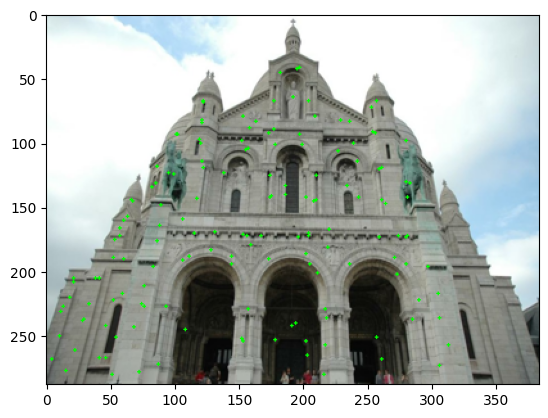

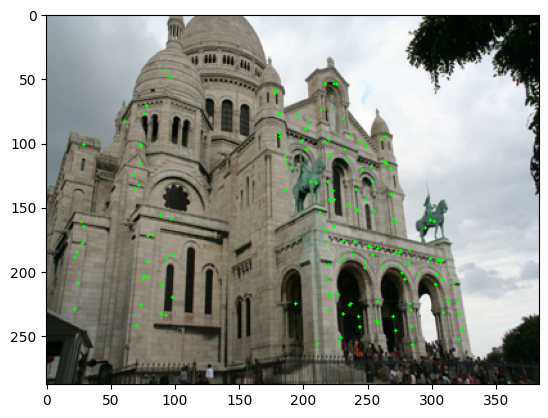

In [22]:
draw_keypoints(im1, pts1)
draw_keypoints(im2, pts2)


In [23]:
pts1.shape

torch.Size([156, 2])

In [19]:
pts2.shape

torch.Size([146, 2])